In [18]:
!pip install sktime
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import os
import random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import datetime as dt

import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import geometric_mean_relative_absolute_error as gmrae
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    r2_score
)
from lightgbm import LGBMRegressor, plot_metric
import optuna

import warnings

#Config
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format
sns.set_style("darkgrid")
colors = sns.color_palette('Set2')

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%%time

df_prices = pd.read_csv('/content/drive/MyDrive/StockPrice/data/stock_prices.csv')
sample = pd.read_csv("/content/drive/MyDrive/StockPrice/data/sample_submission.csv")

CPU times: user 3.12 s, sys: 317 ms, total: 3.43 s
Wall time: 3.78 s


In [22]:
stock_list = pd.read_csv("/content/drive/MyDrive/StockPrice/data/stock_list.csv")

### 0. sample_submission.csv

Для начала взглянем на файл с примером того, как должно выглядеть решение задачи.

In [23]:
sample

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


Посмотрим на количество уникальных значений по столбцам

In [24]:
sample.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

Ранг (Rank) указывает на ранжирование изменения цены закрытия (Close) для дней t+1 и t+2 для каждого дня 2000 акций в убывающем порядке.

### 1. stock_prices.csv

#### *Описание файла*<br>
Основной файл, содержащий дневную цену закрытия для каждой акции и столбец с целевой переменной. Далее представлена информация о столбцах, описанных в `stock_price_spec.csv`:

* `RowId`: Уникальный ID записей о ценах, комбинация `Date` и `SecuritiesCode`.
* `Date`: Дата торгов.
* `SecuritiesCode`: Локальный код ценной бумаги.
* `Open`: Цена открытия акции в этот день.
* `High`: Максимальная цена акции за день.
* `Low`: Минимальная цена акции за день.
* `Close`: Цена закрытия акции в этот день.
* `Volume`: Объем торгуемых акций за день.
* `AdjustmentFactor`: Используется для расчета теоретической цены/объема при дроблении/обратном дроблении акций (НЕ включая дивиденды/распределение акций).
* `ExpectedDividend`: Ожидаемая величина дивидендов на текущую дату. Это значение регистрируется за 2 рабочих дня до даты выплаты дивидендов.
* `SupervisionFlag`: Флаг ценных бумаг, находящихся под надзором, и ценных бумаг, подлежащих исключению из списка.
* `Target`: Изменение соотношения скорректированной цены закрытия между t+2 и t+1, где t+0 - дата сделки.

In [25]:
def summarize(df, file_name, n_rows_to_show=5):
    """Обобщенные данные о таблице.
    
    Параметры:
        df: pd.DataFrame
        file_name: str
        n_rows_to_show: int
    """
    print(f"=====Суммарные данные о {file_name}=====")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("Соотношение пропущенных значений по столбцам:")
    display(nan_ratio)   
    print(f"Первые {n_rows_to_show} строк:")
    display(df.head(n_rows_to_show))
    print(f"Количественные данные:")
    display(df.describe())

In [26]:
summarize(df_prices, "stock_prices.csv")

=====Суммарные данные о stock_prices.csv=====
Размер: 2332531 строк, 12 столбцов
Соотношение пропущенных значений по столбцам:


,ExpectedDividend,Open,High,Low,Close,Target,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,SupervisionFlag
NaN Ratio,99.191222,0.326169,0.326169,0.326169,0.326169,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Первые 5 строк:


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.000000,576.000000,563.000000,571.000000,2798500,1.000000,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.000000,3210.000000,3140.000000,3210.000000,270800,1.000000,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.000000,1550.000000,1510.000000,1550.000000,11300,1.000000,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.000000,3350.000000,3270.000000,3330.000000,150800,1.000000,NaN,False,0.003026


Количественные данные:


,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2332531.000000,2324923.000000,2324923.000000,2324923.000000,2324923.000000,2332531.000000,2332531.000000,18865.000000,2332293.000000
mean,5894.835185,2594.510783,2626.539682,2561.227039,2594.023446,691936.556556,1.000508,22.017730,0.000445
std,2404.161410,3577.191909,3619.363218,3533.494080,3576.538402,3911255.937447,0.067730,29.882453,0.023399
min,1301.000000,14.000000,15.000000,13.000000,14.000000,0.000000,0.100000,0.000000,-0.578541
25%,3891.000000,1022.000000,1035.000000,1009.000000,1022.000000,30300.000000,1.000000,5.000000,-0.010499
50%,6238.000000,1812.000000,1834.000000,1790.000000,1811.000000,107100.000000,1.000000,15.000000,0.000000
75%,7965.000000,3030.000000,3070.000000,2995.000000,3030.000000,402100.000000,1.000000,30.000000,0.010532
max,9997.000000,109950.000000,110500.000000,107200.000000,109550.000000,643654000.000000,20.000000,1070.000000,1.119512


Видно, что в столбце ExpectedDividend 99% значений пропущены. Это объясняется тем, что дивиденты выплачиваются редко

Посмотрим, сколько уникальных дат и акций

In [27]:
n_dates = df_prices['Date'].nunique()
date_min, date_max = df_prices['Date'].min(), df_prices['Date'].max()
n_stocks = df_prices['SecuritiesCode'].nunique()

print(f"Количество уникальных дат: {n_dates} ({date_min} ~ {date_max})\n"
      f"Количество уникальных акций: {n_stocks}")

Количество уникальных дат: 1202 (2017-01-04 ~ 2021-12-03)
Количество уникальных акций: 2000


Посмотрим на корреляционную матрицу

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
SecuritiesCode,1.000000,0.016788,0.016348,0.017235,0.016798,0.040869,0.001716,0.033389,-0.003389
Open,0.016788,1.000000,0.999851,0.999854,0.999730,-0.036524,-0.006918,0.558148,-0.003919
High,0.016348,0.999851,1.000000,0.999756,0.999857,-0.036316,-0.006933,0.557004,-0.003809
Low,0.017235,0.999854,0.999756,1.000000,0.999862,-0.036639,-0.006893,0.558808,-0.003958
Close,0.016798,0.999730,0.999857,0.999862,1.000000,-0.036473,-0.006907,0.558037,-0.003852
Volume,0.040869,-0.036524,-0.036316,-0.036639,-0.036473,1.000000,0.005304,-0.019052,-0.000873
AdjustmentFactor,0.001716,-0.006918,-0.006933,-0.006893,-0.006907,0.005304,1.000000,NaN,-0.000091
ExpectedDividend,0.033389,0.558148,0.557004,0.558808,0.558037,-0.019052,NaN,1.000000,-0.148628
Target,-0.003389,-0.003919,-0.003809,-0.003958,-0.003852,-0.000873,-0.000091,-0.148628,1.000000


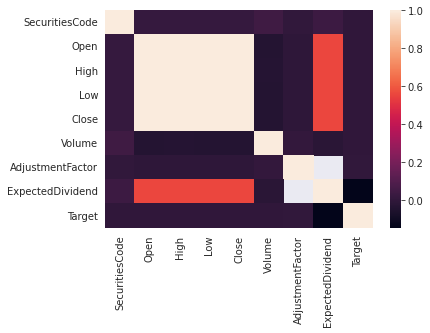

In [28]:
cols = ['SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'Target']
correlation_matrix = df_prices[cols].corr()
display(correlation_matrix)
sns.heatmap(correlation_matrix)

Посмотрим распределение количества акций к количеству дней, за которые имеются записи о той или иной акции

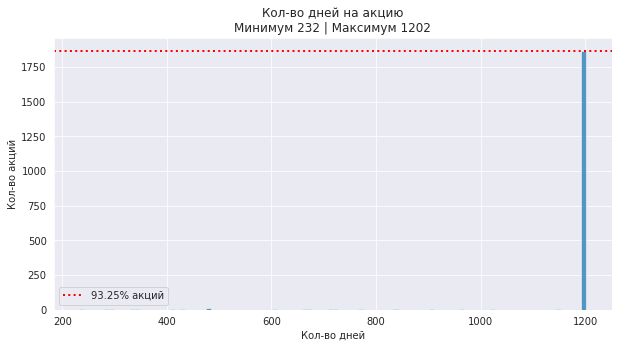

In [29]:
n_dates_per_stock = df_prices.groupby(['SecuritiesCode'])['Date'].count()
stock_cnt_max = (n_dates_per_stock == n_dates_per_stock.max()).sum()
stock_ratio_max = stock_cnt_max / len(n_dates_per_stock) * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_dates_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% акций')
ax.set_title(f"Кол-во дней на акцию\nМинимум {n_dates_per_stock.min()} | "
             f"Максимум {n_dates_per_stock.max()}")
ax.set_xlabel("Кол-во дней")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Примерно 90% акций имеют записи за весь период

Посмотрим распределение количества дней к количеству акций, которые торговались в этот день

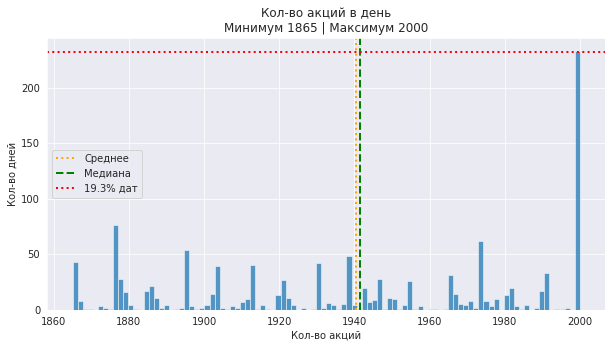

In [30]:
n_stocks_per_date = df_prices.groupby(['Date'])['SecuritiesCode'].count()
date_cnt_max = (n_stocks_per_date == n_stocks_per_date.max()).sum()
date_ratio_max = round(date_cnt_max / len(n_stocks_per_date) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=n_stocks_per_date.values, bins=100, palette=colors, ax=ax)
ax.axvline(x=n_stocks_per_date.mean(), color='orange', linestyle='dotted',
           linewidth=2, label='Среднее')
ax.axvline(x=n_stocks_per_date.median(), color='green', linestyle='--',
           linewidth=2, label='Медиана')
ax.axhline(y=date_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{date_ratio_max}% дат')
ax.set_title(f"Кол-во акций в день\nМинимум {n_stocks_per_date.min()} | "
             f"Максимум {n_stocks_per_date.max()}")
ax.set_xlabel("Кол-во акций")
ax.set_ylabel("Кол-во дней")
ax.legend()
plt.show()

Примерно только 20% торговых дней имеют записи о всех акциях

#### Работа с пропущенными значениями
Остановимся на записях с пропущенными значениями.

In [31]:
df_no_prices = df_prices[df_prices['Close'].isna()]
print(f"Количество записей без цены: {len(df_no_prices)}")

Количество записей без цены: 7608


Посмотрим кол-во акций с пропущенными ценами по дням

In [32]:
no_prices_per_date = df_no_prices['Date'].value_counts().sort_index()
all_dates = sorted(df_prices['Date'].unique())
no_prices_per_date = no_prices_per_date.reindex(all_dates, fill_value=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=no_prices_per_date.index, 
                         y=no_prices_per_date, 
                         mode='lines'))
rect_focus_params = {
    'xref': 'x', 'yref': 'y', 'x0': '2020-09-25', 'x1': '2020-10-08',
    'y0': 1900, 'y1': 2000, 'line': {'color': 'red', 'width': 1.5}
}
fig.add_shape(type='rect', **rect_focus_params)
fig.update_layout(
    title=f"Кол-во акций с пропущенными ценами по дням",
    xaxis_title="День",
    yaxis_title="Кол-во акций",
)
fig.show()

Больше всего акций с пропущенными ценами 1 октября 2020 года. Это связано с техническими проблемами на Токийской бирже в этот день

Посмотрим теперь, наоборот, кол-во дней с пропущенными ценами для каждой акции

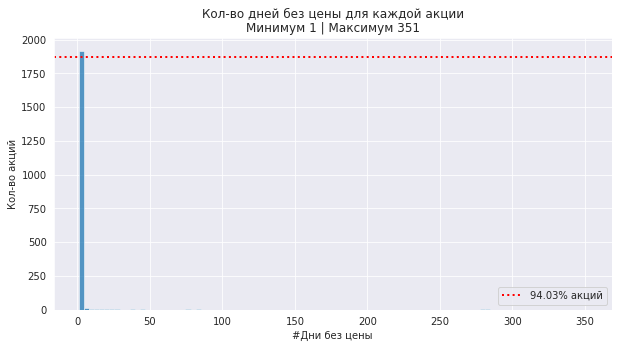

In [33]:
no_prices_per_stock = df_no_prices['SecuritiesCode'].value_counts()
stock_cnt_max = (no_prices_per_stock == no_prices_per_stock.min()).sum()
stock_ratio_max = round(stock_cnt_max / len(no_prices_per_stock) * 100, 2)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=no_prices_per_stock.values, bins=100, palette=colors, ax=ax)
ax.axhline(y=stock_cnt_max, color='red', linestyle='dotted', linewidth=2,
           label=f'{stock_ratio_max}% акций')
ax.set_title(f"Кол-во дней без цены для каждой акции\n"
             f"Минимум {no_prices_per_stock.min()} | "
             f"Максимум {no_prices_per_stock.max()}")
ax.set_xlabel("#Дни без цены")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Заполним пропущенные значения в столбце с дивидендами нулями, остальные строки с пропущенными значениями удалим

In [34]:
df_prices['ExpectedDividend'] = df_prices['ExpectedDividend'].fillna(0)
df_prices = df_prices.dropna()
df_prices.isnull().sum()

RowId               0
Date                0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Target              0
dtype: int64

#### Исследование целевой переменной

Целевая переменная (Target) определяется на основе приведенной ниже формулы:

![\Large r_{(k,t)}=\frac{C_{(k,t+2)}-C_{(k,t+1)}}{C_{(k,t+1)}}](https://latex.codecogs.com/svg.image?r_{(k,t)}=\frac{C_{(k,t&plus;2)}-C_{(k,t&plus;1)}}{C_{(k,t&plus;1)}}) 

In [35]:
df = df_prices[df_prices['SecuritiesCode'] == 1301]
df["Close_shift1"] = df["Close"].shift(-1)
df["Close_shift2"] = df["Close"].shift(-2)

df["rate"] = (df["Close_shift2"] - df["Close_shift1"]) / df["Close_shift1"]
df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Close_shift1,Close_shift2,rate
0,20170104_1301,2017-01-04,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,0.000000,False,0.000730,2738.000000,2740.000000,0.000730
1865,20170105_1301,2017-01-05,1301,2743.000000,2747.000000,2735.000000,2738.000000,17900,1.000000,0.000000,False,0.002920,2740.000000,2748.000000,0.002920
3730,20170106_1301,2017-01-06,1301,2734.000000,2744.000000,2720.000000,2740.000000,19900,1.000000,0.000000,False,-0.001092,2748.000000,2745.000000,-0.001092
5595,20170110_1301,2017-01-10,1301,2745.000000,2754.000000,2735.000000,2748.000000,24200,1.000000,0.000000,False,-0.005100,2745.000000,2731.000000,-0.005100
7460,20170111_1301,2017-01-11,1301,2748.000000,2752.000000,2737.000000,2745.000000,9300,1.000000,0.000000,False,-0.003295,2731.000000,2722.000000,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322531,20211129_1301,2021-11-29,1301,2975.000000,2984.000000,2951.000000,2951.000000,14300,1.000000,0.000000,False,0.003793,2900.000000,2911.000000,0.003793
2324531,20211130_1301,2021-11-30,1301,2953.000000,2997.000000,2900.000000,2900.000000,20500,1.000000,0.000000,False,0.007558,2911.000000,2933.000000,0.007558
2326531,20211201_1301,2021-12-01,1301,2909.000000,2936.000000,2909.000000,2911.000000,10600,1.000000,0.000000,False,0.016706,2933.000000,2982.000000,0.016706
2328531,20211202_1301,2021-12-02,1301,2949.000000,2973.000000,2933.000000,2933.000000,15200,1.000000,0.000000,False,-0.003689,2982.000000,NaN,NaN


Столбец rate, полученный по формуле и Target, идентичны

Взглянем на пример изменения цены акции

In [36]:
print(f'Акция №{df["SecuritiesCode"].iloc[0]}\nЦена на t+1 день: {df["Close_shift1"].iloc[0]}\nЦена на t+2 день: {df["Close_shift2"].iloc[0]}\nИзменение цены: {df["rate"].iloc[0] * 100}%')

Акция №1301
Цена на t+1 день: 2738.0
Цена на t+2 день: 2740.0
Изменение цены: 0.07304601899196494%


Сделаем функцию, которая для каждой акции строит OHLC (Open, High, Low, Close)
график, график изменения объема, а также график изменения целевой переменной

In [37]:
def plot_candle_with_target(stock_code, prime=True):
    df_ = df_prices.copy() if prime else df_prices_sec.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Объем (Volume)'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Целевая'),
                  row=3, col=1)
    fig.update_layout(
        title=f"График OHLCV и график целевой переменной (Акция №{stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [38]:
for stock_code in df_prices['SecuritiesCode'].unique()[:3]:
    plot_candle_with_target(stock_code)

Посмотрим на распределение средних значений целевой переменной

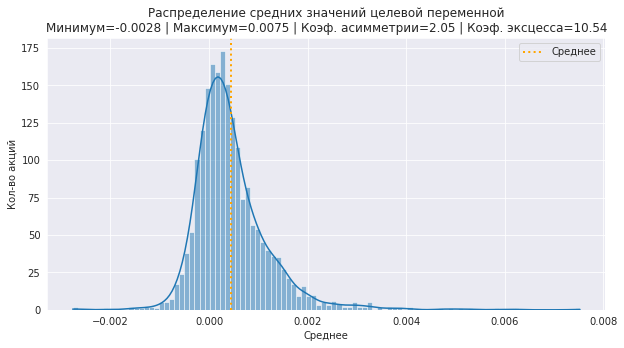

In [39]:
target_mean_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_mean = target_mean_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Распределение средних значений целевой переменной\n"
             f"Минимум={round(target_mean_per_stock.min(), 4)} | "
             f"Максимум={round(target_mean_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_mean_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_mean_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Среднее")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Распределение средних значений целевой переменной - это распределение, смещенное вправо. Кроме того, оно имеет большой эксцесс с хвостовыми данными, превышающими хвосты нормального распределения. Для инвесторов высокий эксцесс распределения доходности подразумевает, что инвестор будет время от времени испытывать экстремальную доходность (положительную или отрицательную). Это явление известно как риск эксцесса.

Посмотрим на стандартное распределение целевой переменной

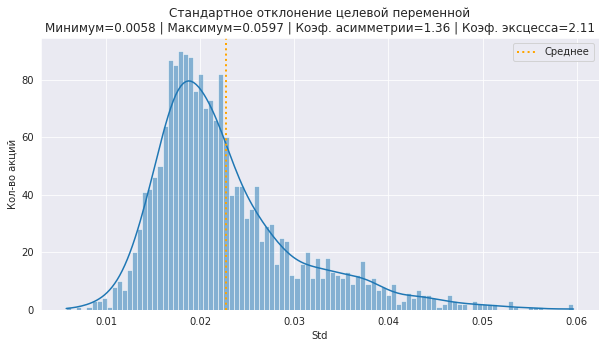

In [40]:
target_std_per_stock = df_prices.groupby(['SecuritiesCode'])['Target'].std()
target_std_mean = target_std_per_stock.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_std_per_stock.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_std_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Стандартное отклонение целевой переменной\n"
             f"Минимум={round(target_std_per_stock.min(), 4)} | "
             f"Максимум={round(target_std_per_stock.max(), 4)} | "
             f"Коэф. асимметрии={round(target_std_per_stock.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_std_per_stock.kurtosis(), 2)}")
ax.set_xlabel("Std")
ax.set_ylabel("Кол-во акций")
ax.legend()
plt.show()

Среднеквадратическое отклонение  целевой переменной снова представляет собой распределение, смещенное вправо, где некоторые акции имеют более высокий std (до 0,06).

In [41]:
tm_max = target_mean_per_stock.max()
stock_tm_max = target_mean_per_stock[target_mean_per_stock == tm_max].index.values[0]

print(f"Ценная бумага с наибольшим средним Target: {stock_tm_max}.")
plot_candle_with_target(stock_tm_max)

Ценная бумага с наибольшим средним Target: 4169.


Акция 4169 это Enechange Ltd, японская компания по разработке инструментов для обеспечения альтернативных видов энергии.

Посмотрим на среднее распределение целевой переменной по дням

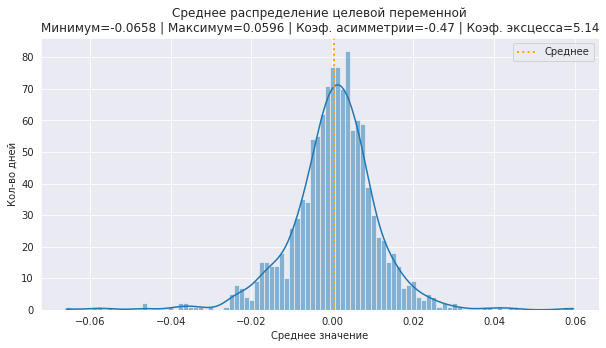

In [42]:
target_mean_per_date = df_prices.groupby(['Date'])['Target'].mean()
target_mean_mean = target_mean_per_date.mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=target_mean_per_date.values, bins=100, palette=colors, kde=True,
             ax=ax)
ax.axvline(x=target_mean_mean, color='orange', linestyle='dotted', linewidth=2, 
           label='Среднее')
ax.set_title("Среднее распределение целевой переменной\n"
             f"Минимум={round(target_mean_per_date.min(), 4)} | "
             f"Максимум={round(target_mean_per_date.max(), 4)} | "
             f"Коэф. асимметрии={round(target_mean_per_date.skew(), 2)} | "
             f"Коэф. эксцесса={round(target_mean_per_date.kurtosis(), 2)}")
ax.set_xlabel("Среднее значение")
ax.set_ylabel("Кол-во дней")
ax.legend()
plt.show()

In [43]:
tm_max = target_mean_per_date.max()
date_tm_max = target_mean_per_date[target_mean_per_date == tm_max].index.values[0]
print(f"Дата с максимальным средним значением целевой переменной: {date_tm_max}.")

Дата с максимальным средним значением целевой переменной: 2018-12-25.


Построим графики возврата инвестиций

In [44]:
def plot_return(stock_code):
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [20, 40, 60]
    cols = []

    for period in periods:
        col = f"Доходность {period // 20} месяц(-а)"
        df_[col] = df_["Close"].pct_change(period)
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Доходность, акция {stock_code}', height = 350)
    fig.show()

In [45]:
N = random.randint(0, 1997)
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_return(stock_code)

#### Скользящее среднее

Скользящие средние - это простой и распространенный тип сглаживания, используемый в анализе и прогнозировании временных рядов.

In [46]:
def plot_moving_average(stock_code):
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [5, 15, 25]
    cols = []

    for period in periods:
        col = f"Простое скользящее среднее с окном {period}"
        df_[col] = df_["Close"].rolling(period, min_periods=1).mean()
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Скользящее среднее, акция {stock_code}', height = 350)
    fig.show()

In [47]:
N = random.randint(0, 1997)
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_moving_average(stock_code)

Посмотрим на волатильность акций

In [48]:
def plot_volatility(stock_code):
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    
    periods = [5, 25, 75]
    cols = []

    for period in periods:
        col = f"Волатильность с окном {period}"
        df_[col] = np.log(df_["Close"]).diff().rolling(period).std()
        cols.append(col)

    fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Волатильность')

    for col in cols:
        fig.add_trace( 
            go.Scatter(
                x = df_['Date'],
                y = df_[col],
                name = f'{col}'
            )
        )
    fig.update_layout(template = 'presentation', title = f'Волатильность, акция {stock_code}', height = 350)
    fig.show()

In [49]:
N = random.randint(0, 1997)
for stock_code in df_prices['SecuritiesCode'].unique()[N:N+3]:
    plot_volatility(stock_code)

### 2. stocks_list.csv

In [50]:
summarize(stock_list, "stock_list.csv", n_rows_to_show=2)

=====Суммарные данные о stock_list.csv=====
Размер: 4417 строк, 16 столбцов
Соотношение пропущенных значений по столбцам:


,NewMarketSegment,TradeDate,Close,IssuedShares,MarketCapitalization,SecuritiesCode,EffectiveDate,Name,Section/Products,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,Universe0
NaN Ratio,14.602671,6.701381,6.701381,6.701381,6.701381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Первые 2 строк:


,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.000000,3080.000000,10928283.000000,33659111640.000000,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.000000,2097.000000,3634635625.000000,7621830905625.000000,False


Количественные данные:


,SecuritiesCode,EffectiveDate,TradeDate,Close,IssuedShares,MarketCapitalization
count,4417.000000,4417.000000,4121.000000,4121.000000,4121.000000,4121.000000
mean,5547.191306,20197579.726738,20211229.954137,6376.734700,89922667.041686,218440012227.214966
std,2499.027227,51968.418358,0.510647,38091.520255,487167544.354170,1309480999287.264404
min,1301.000000,20000101.000000,20211216.000000,1.800000,2242.000000,38786600.000000
25%,3423.000000,20211230.000000,20211230.000000,728.000000,5944100.000000,5912841000.000000
50%,5711.000000,20211230.000000,20211230.000000,1397.000000,14950074.000000,18225000000.000000
75%,7616.000000,20211230.000000,20211230.000000,2595.000000,42678998.000000,68114880000.000000
max,25935.000000,20220225.000000,20211230.000000,711000.000000,16314987460.000000,52192239810720.000000


ТОП-10 фондов/компаний по капитализации

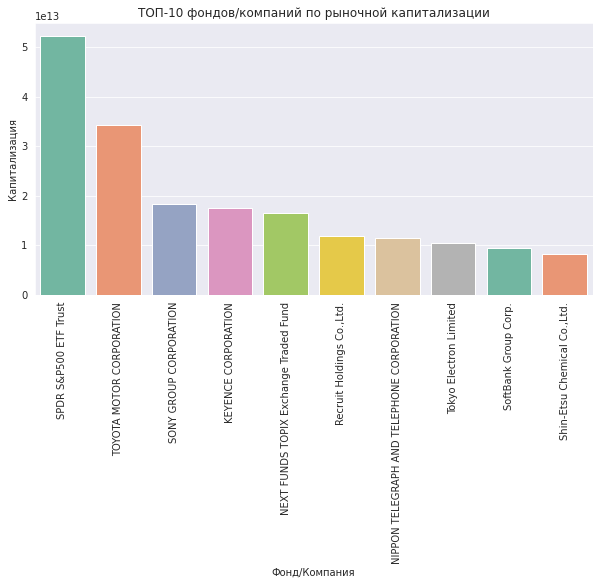

In [51]:
top_by_cap = stock_list.sort_values('MarketCapitalization', ascending=False)[['Name','MarketCapitalization']][:10]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_by_cap['Name'].values, y=top_by_cap['MarketCapitalization'].values, 
            palette=colors, ax=ax)
ax.set_title("ТОП-10 фондов/компаний по рыночной капитализации")
ax.set_xlabel("Фонд/Компания")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Капитализация")
plt.show()

Взглянем на распределение сфер с помощью круговой диаграммы

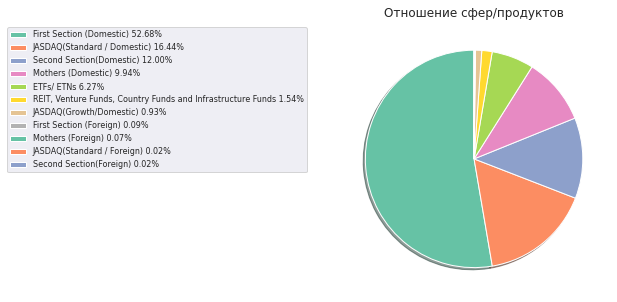

In [52]:
sec_prod_val_cnt = stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=colors, 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Отношение сфер/продуктов")
plt.show()

Взглянем на распределение сфер с помощью круговой диаграммы среди топ-2000 акций

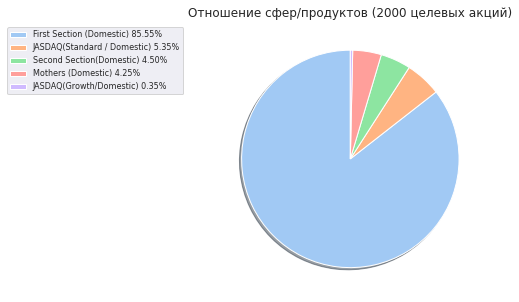

In [53]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_prod_val_cnt = target_stock_list['Section/Products'].value_counts()
pct = sec_prod_val_cnt / sec_prod_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_prod_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_prod_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_prod_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Отношение сфер/продуктов (2000 целевых акций)")
plt.show()

По секторам

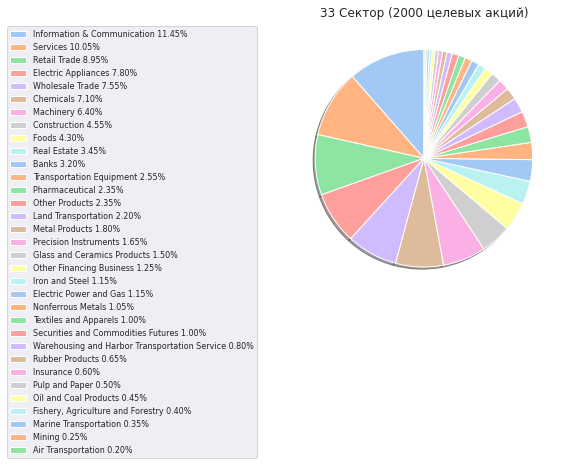

In [54]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("33 Сектор (2000 целевых акций)")
plt.show()

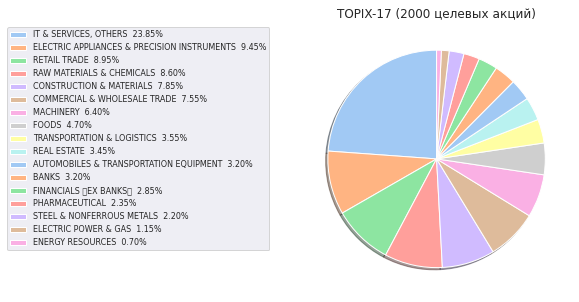

In [55]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_17_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_17_val_cnt.values, 
                        colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("TOPIX-17 (2000 целевых акций)")
plt.show()

Присоединим некоторые столбцы из `stock_list` к `df_prices` для секторального анализа

In [56]:
sec_info = target_stock_list[['SecuritiesCode', '33SectorName', '33SectorCode', '17SectorCode', '17SectorName']]
df_prices = pd.merge(df_prices, sec_info, on='SecuritiesCode')
df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,33SectorName,33SectorCode,17SectorCode,17SectorName
0,20170104_1301,2017-01-04,1301,2734.000000,2755.000000,2730.000000,2742.000000,31400,1.000000,0.000000,False,0.000730,"Fishery, Agriculture and Forestry",50,1,FOODS
1,20170105_1301,2017-01-05,1301,2743.000000,2747.000000,2735.000000,2738.000000,17900,1.000000,0.000000,False,0.002920,"Fishery, Agriculture and Forestry",50,1,FOODS
2,20170106_1301,2017-01-06,1301,2734.000000,2744.000000,2720.000000,2740.000000,19900,1.000000,0.000000,False,-0.001092,"Fishery, Agriculture and Forestry",50,1,FOODS
3,20170110_1301,2017-01-10,1301,2745.000000,2754.000000,2735.000000,2748.000000,24200,1.000000,0.000000,False,-0.005100,"Fishery, Agriculture and Forestry",50,1,FOODS
4,20170111_1301,2017-01-11,1301,2748.000000,2752.000000,2737.000000,2745.000000,9300,1.000000,0.000000,False,-0.003295,"Fishery, Agriculture and Forestry",50,1,FOODS


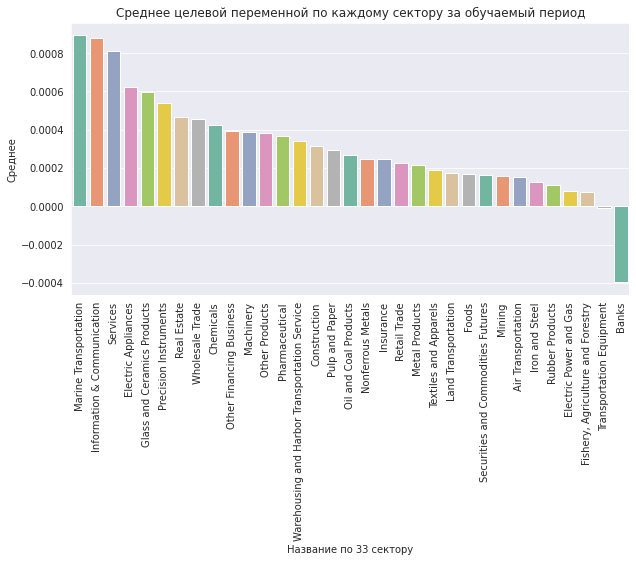

In [57]:
target_mean_33sec = df_prices.groupby(['33SectorName'])['Target'].mean()
target_mean_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_33sec.index, y=target_mean_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по каждому сектору за обучаемый период")
ax.set_xlabel("Название по 33 сектору")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Среднее")
plt.show()

С более широкой точки зрения, можно заметить, что морские перевозки имеют самый высокий целевой показатель за период обучения, за которым следуют IT и услуги. И единственный сектор, имеющий отрицательное целевое среднее значение, - это банки.

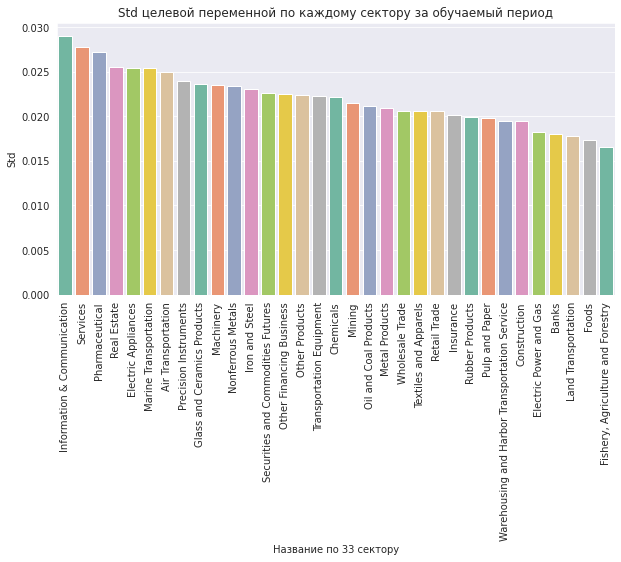

In [58]:
target_std_33sec = df_prices.groupby(['33SectorName'])['Target'].std()
target_std_33sec.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_std_33sec.index, y=target_std_33sec.values, 
            palette=colors, ax=ax)
ax.set_title("Std целевой переменной по каждому сектору за обучаемый период")
ax.set_xlabel("Название по 33 сектору")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Std")
plt.show()

Что касается целевой дисперсии, сфера IT имеет самое высокое целевое среднеквадратическое отклонение (std) за период обучения, за которым следуют Услуги и фармацевтика. А в рыболовстве, сельском хозяйстве и лесном хозяйстве std самое низкое.

Посмотрим на морские перевозки, отрасль с набиольшим средним целевым значением.

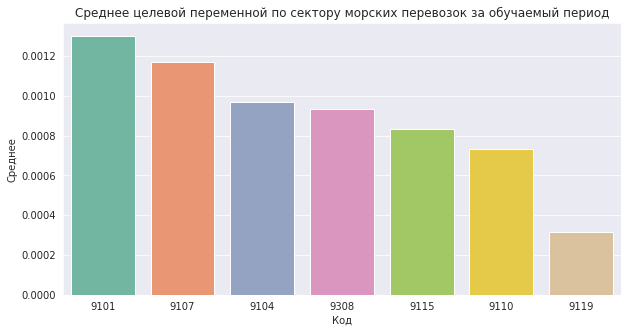

In [59]:
target_sector = 'Marine Transportation'
df_prices_marine = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_marine = df_prices_marine.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_marine.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_marine.index, y=target_mean_marine.values, 
            order=target_mean_marine.index, palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по сектору морских перевозок за обучаемый период")
ax.set_xlabel("Код")
ax.set_ylabel("Среднее")
plt.show()

Топ-3 акций по среднему целевому значению это Nippon Yusen K.K. (9101), Kawasaki Kisen Kaisha, Ltd. (9107), и Mitsui OSK Lines, Ltd. (9104).

Построим график изменения целевой пермеменной для этих акций.

In [60]:
unique_dates = sorted(df_prices['Date'].unique())

fig = go.Figure()
for stock_code in [9101, 9107, 9104]:
    df_ = df_prices_marine[df_prices_marine['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Ряды целевой переменной для ТОП-3 акций в области морских перевозок",
)
fig.show()

Интерпретируя целевые ряды в дневном масштабе, можно обнаружить, что акции в одной и той же отрасли имеют сильную пространственную зависимость, то есть целевые ряды перемещаются синхронно.

Взглянем теперь на худшую отрасль, Банки

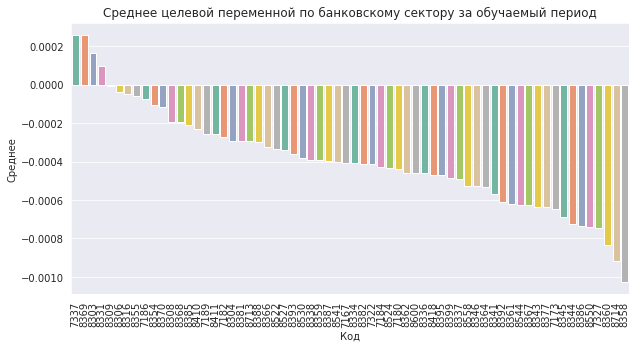

In [61]:
target_sector = 'Banks'
df_prices_banks = df_prices[df_prices['33SectorName'] == target_sector]
target_mean_banks = df_prices_banks.groupby(['SecuritiesCode'])['Target'].mean()
target_mean_banks.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=target_mean_banks.index, y=target_mean_banks.values, 
            order=target_mean_banks.index, palette=colors, ax=ax)
ax.set_title("Среднее целевой переменной по банковскому сектору за обучаемый период")
ax.set_xlabel("Код")
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Среднее")
plt.show()

Как мы видим, поведение банковского сектора значительно отличается от поведения лучшего сектора - морских перевозок. Только пять акций имеют положительные целевые значения. А у Suruga Bank Ltd. (8358) в среднем худшие показатели.

Посмотрим на ряды целевой переменной среди топ-3 худших компаний в банковском секторе

In [62]:
fig = go.Figure()
for stock_code in [8360, 8714, 8358]:
    df_ = df_prices_banks[df_prices_banks['SecuritiesCode'] == stock_code]
    fig.add_trace(go.Scatter(x=unique_dates, y=df_['Target'], name=stock_code))
fig.update_layout(
    title=f"Графики целевой переменной среди топ-3 худших компаний в банковском секторе",
)
fig.show()

Акции в пределах одного и того же сектора имеют определенную взаимосвязь друг с другом. То есть ряды перемещаются синхронно.

Составим сводную таблицу по дате и коду, со значениями целевой переменной:

In [63]:
stockspivot = pd.pivot(df_prices, index = 'Date', values = 'Target', columns = 'SecuritiesCode')
stockspivot = stockspivot.ffill().fillna(0)
stockspivot.index = pd.to_datetime(stockspivot.index)

stockspivot.head()

SecuritiesCode,1301,1332,1333,1375,1376,1377,1379,1381,1407,1413,...,9982,9983,9984,9987,9989,9990,9991,9993,9994,9997
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.000730,0.012324,0.006154,0.000000,0.011053,0.003026,0.005169,-0.009326,-0.003437,0.000000,...,0.017204,-0.067387,0.025757,0.001280,0.029412,-0.022117,0.000000,0.015042,-0.001132,0.007481
2017-01-05,0.002920,-0.022609,-0.010703,0.000000,0.005145,0.004525,-0.008883,0.019874,-0.009006,0.000000,...,-0.004228,-0.025932,0.007174,-0.014066,0.010714,-0.018578,0.016859,0.025796,-0.008499,-0.004950
2017-01-06,-0.001092,-0.016014,-0.015456,0.000000,0.000000,-0.033033,-0.005189,-0.007692,-0.019528,0.000000,...,0.000000,-0.003360,0.008548,0.007782,0.011779,-0.012346,0.005236,-0.016586,0.000000,-0.006219
2017-01-10,-0.005100,-0.016275,-0.001570,0.000000,-0.026871,0.046584,-0.007112,0.000000,0.004733,0.000000,...,0.000000,-0.014263,-0.007652,-0.029601,-0.034924,-0.019167,-0.004340,-0.003264,-0.015429,-0.028786
2017-01-11,-0.003295,0.016544,0.015723,0.000000,0.011177,-0.010386,-0.008118,0.001034,0.000000,0.000000,...,0.006369,0.011050,0.005575,0.002653,0.022919,-0.005947,0.002616,0.000000,0.007545,0.009021


In [64]:
decision_date = '2021-02-01'
window = 10
observations = stockspivot.loc[:decision_date].iloc[-2-window:].cumsum()
futurforecast = stockspivot.loc[decision_date:].iloc[:window].cumsum()

good_stocks = futurforecast.iloc[-1].sort_values().index[-20:][::-1]
bad_stocks = futurforecast.iloc[-1].sort_values().index[:20][::-1]

fig = go.Figure()
for i, stock_viz in enumerate(good_stocks):
  
    fig.add_trace(
        go.Scatter(
            x = observations.index,
            y = observations[stock_viz].values,
            marker = {'color':'green'},
            showlegend = False,
            mode = 'lines',
            opacity = 0.2,
            name = stock_viz
        )
    )

    fig.add_trace(
        go.Scatter(
            x = futurforecast.index,
            y = futurforecast[stock_viz].values,
            marker = {'color':'green'},
            showlegend=False,
            mode = 'lines',
            opacity = 0.2,
            name = stock_viz
        )
    )
    

for i, stock_viz in enumerate(bad_stocks):

    fig.add_trace(
        go.Scatter(
            x = observations.index,
            y = observations[stock_viz].values,
            marker = {'color':'red'},
            showlegend = False,
            mode = 'lines',
            opacity = 0.2,
            name = stock_viz
        )
    )

    fig.add_trace(
        go.Scatter(
            x = futurforecast.index,
            y = futurforecast[stock_viz].values,
            marker = {'color':'red'},
            showlegend=False,
            mode = 'lines',
            opacity = 0.2,
            name = stock_viz
        )
    )


fig.update_layout(template = 'presentation', title = f'Параллельные графики, лучшие vs худшие акции в периоде', height = 400) 
fig.show()

## Построение модели
Будем использовать LightGBM.

Добавим новые признаки

In [65]:
def get_features_for_predict(price, code, start_dt=pd.Timestamp(2017, 3, 1)):
    df_ = df_prices.copy()
    
    feats = df_[df_.SecuritiesCode == code]
    feats['Date'] = pd.to_datetime(feats['Date'])
    feats = feats.select_dtypes(include=["float64","int64", "datetime64"])
    
    # Доходность, изменение цены закрытия за 20 рабочих дней
    feats["return_1month"] = feats["Close"].pct_change(20)
    # Доходность, изменение цены закрытия за 40 рабочих дней
    feats["return_2month"] = feats["Close"].pct_change(40)
    # Доходность, изменение цены закрытия за 60 рабочих дней
    feats["return_3month"] = feats["Close"].pct_change(60)
    # волатильность за 20 дней
    feats["volatility_1month"] = (
        np.log(feats["Close"]).diff().rolling(20).std()
    )
    # волатильность за 40 дней
    feats["volatility_2month"] = (
        np.log(feats["Close"]).diff().rolling(40).std() 
    )
    # волатильность за 60 дней
    feats["volatility_3month"] = (
        np.log(feats["Close"]).diff().rolling(60).std()
    )
    # Разница между ценой закрытия и 20-дневной простой скользящей средней
    feats["MA_gap_1month"] = feats["Close"] / (
        feats["Close"].rolling(20).mean()
    )
    # Разница между ценой закрытия и 40-дневной простой скользящей средней
    feats["MA_gap_2month"] = feats["Close"] / (
        feats["Close"].rolling(40).mean()
    )
    # Разница между ценой закрытия и 60-дневной простой скользящей средней
    feats["MA_gap_3month"] = feats["Close"] / (
        feats["Close"].rolling(60).mean()
    )
    
    #Фильтрация с указанного дня
    feats = feats.loc[feats.Date > start_dt] #

    return feats

In [151]:
%%time

codes = df_prices.SecuritiesCode.unique()
df_prices_new = get_features_for_predict(df_prices, codes[0])
for code in tqdm(codes[1:]):
    df_prices_new = pd.concat([df_prices_new, get_features_for_predict(df_prices, code)])
df_prices_new = df_prices_new.sort_values(by=['Date', 'SecuritiesCode']).reset_index().drop(["index"], axis=1).fillna(0)
df_prices_new

  0%|          | 0/1999 [00:00<?, ?it/s]

CPU times: user 7min 20s, sys: 17.5 s, total: 7min 38s
Wall time: 7min 39s


,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month
0,2017-03-02,1301,3030.000000,3035.000000,3015.000000,3020.000000,52500,1.000000,0.000000,0.023026,0.106632,0.101386,0.000000,0.005480,0.005780,0.000000,1.060803,1.083991,0.000000
1,2017-03-02,1332,565.000000,568.000000,562.000000,567.000000,3055100,1.000000,0.000000,-0.022928,0.048059,-0.007005,0.000000,0.022672,0.021129,0.000000,0.994475,1.012410,0.000000
2,2017-03-02,1333,3415.000000,3435.000000,3390.000000,3400.000000,241900,1.000000,0.000000,0.011577,0.093248,0.059190,0.000000,0.016400,0.014191,0.000000,1.025023,1.045872,0.000000
3,2017-03-02,1376,1480.000000,1480.000000,1470.000000,1471.000000,3100,1.000000,0.000000,0.004785,0.010302,-0.050968,0.000000,0.007906,0.009649,0.000000,1.016410,0.993869,0.000000
4,2017-03-02,1377,3205.000000,3245.000000,3190.000000,3235.000000,116000,1.000000,0.000000,-0.004644,0.006221,-0.028529,0.000000,0.010633,0.014874,0.000000,1.014902,1.000928,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250547,2021-12-03,9990,514.000000,528.000000,513.000000,528.000000,44200,1.000000,0.000000,0.034816,-0.147011,-0.062167,-0.052065,0.022620,0.022582,0.020410,0.935424,0.937375,0.934899
2250548,2021-12-03,9991,782.000000,794.000000,782.000000,794.000000,35900,1.000000,0.000000,0.025478,-0.034063,-0.082081,-0.119734,0.015520,0.015145,0.013716,0.987869,0.947353,0.923471
2250549,2021-12-03,9993,1690.000000,1690.000000,1645.000000,1645.000000,7200,1.000000,0.000000,-0.004302,-0.043048,-0.046377,-0.056225,0.006163,0.006260,0.007898,0.964555,0.962284,0.955238
2250550,2021-12-03,9994,2388.000000,2396.000000,2380.000000,2389.000000,6500,1.000000,0.000000,0.009098,-0.026487,-0.012402,-0.054236,0.007357,0.007663,0.008449,0.996538,0.993688,0.978557


Добавим день, месяц и год в признаки

In [152]:
df_prices_new['Day'] = df_prices_new['Date'].dt.day
df_prices_new['Month'] = df_prices_new['Date'].dt.month
df_prices_new['Year'] = df_prices_new['Date'].dt.year

Сохраним новую таблицу, чтобы не генерировать ее каждый раз

In [ ]:
df_prices_new.to_csv('stock_prices_with_features.csv')

Функция для вывода графика цены закрытия

In [153]:
def plot_closing_price(data, stock_code):
  df_ = data[data['SecuritiesCode'] == stock_code]
  df_['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
  
  fig = make_subplots(rows=1, cols=1, x_title='Дата', y_title='Цена')

  fig.add_trace( 
      go.Scatter(
          x = df_['Date'],
          y = df_['Close'],
      )
  )
  fig.update_layout(template = 'presentation', title = f'Цена закрытия, акция {stock_code}', height = 350)
  fig.show()

Функции для сглаживания значений цены закрытия и целевой переменной: экспоненциальная и обычная скользящая средняя

In [154]:
def smoothen_ema(data, code, period=15):
  df_ = data[data['SecuritiesCode'] == code]
  df_['Close'] = df_["Close"].ewm(span=period, adjust=False).mean()
  df_["Target"] = (df_["Close"].shift(-2) - df_["Close"].shift(-1)) / df_["Close"].shift(-1)
  return df_

In [155]:
def smoothen_ma(data, code, period=15):
  df_ = data[data['SecuritiesCode'] == code]
  df_['Close'] = df_["Close"].rolling(period, min_periods=1).mean()
  df_["Target"] = (df_["Close"].shift(-2) - df_["Close"].shift(-1)) / df_["Close"].shift(-1)
  return df_

Сгенерируем сглаженные датасеты

In [156]:
%%time

codes = df_prices_new['SecuritiesCode'].unique()

df_prices_smooth_ema = smoothen_ema(df_prices_new, codes[0])
for code in tqdm(codes[1:]):
    df_prices_smooth_ema = pd.concat([df_prices_smooth_ema, smoothen_ema(df_prices_new, code)])
df_prices_smooth_ema = df_prices_smooth_ema.sort_values(by=['Date', 'SecuritiesCode']).reset_index().drop(["index"], axis=1).dropna()

  0%|          | 0/1999 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 7.29 s, total: 1min 38s
Wall time: 1min 35s


Сохраним сглаженные датасеты

In [ ]:
df_prices_smooth_ma.to_csv('stock_prices_with_features_smooth_ma.csv')

In [ ]:
df_prices_smooth_ema.to_csv('stock_prices_with_features_smooth_ema.csv')

Выведем разницу между обычной и сглаженной ценой закрытия для двух скользящих средних

In [157]:
randcode = 9733
plot_closing_price(df_prices_new, randcode)
plot_closing_price(df_prices_smooth_ema, randcode)

Если файл сохранен, будем загружать датасет с новыми признаками из файла

In [ ]:
%%time
df_prices_new = pd.read_csv('stock_prices_with_features.csv', index_col=0)

Wall time: 4.37 s


In [ ]:
df_prices_smooth_ema = pd.read_csv('stock_prices_with_features_smooth_ema.csv', index_col=0)

Преобразуем дату в числовой формат

In [158]:
df_prices_new['Date'] = df_prices_new['Date'].dt.strftime("%Y%m%d").astype(int)

In [159]:
df_prices_smooth_ema['Date'] = pd.to_datetime(df_prices_smooth_ema['Date'])
df_prices_smooth_ema['Date'] = df_prices_smooth_ema['Date'].dt.strftime("%Y%m%d").astype(int)

Разобьем данные на X и y

In [97]:
X = df_prices_new.drop(['Target'], axis=1)
y = df_prices_new['Target']

In [160]:
X = df_prices_smooth_ema.drop(['Target'], axis=1)
y = df_prices_smooth_ema['Target']

Кросс-валидация

In [161]:
def setup_cv(df, splits=5):
    df['fold'] = -1
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(
        df["Target"], bins=num_bins, labels=False
    )

    kf = StratifiedKFold(n_splits=splits)
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df.bins.values)):
            df.loc[v_, 'fold'] = f

    df = df.drop("bins", axis=1)
    return df

In [ ]:
df_prices_new

In [99]:
df_prices_new = setup_cv(df_prices_new)

In [162]:
df_prices_smooth_ema = setup_cv(df_prices_smooth_ema)

Обучение модели LGBM на фолдах

In [163]:
def train_lgbm(prices, folds):
    models = list()
    
    for f in range(folds):
        X_train = prices[prices.fold != f].drop(['Target', 'fold'], axis=1)
        y_train = prices[prices.fold != f][["Target"]]
        X_valid = prices[prices.fold == f].drop(['Target', 'fold'], axis=1)
        y_valid = prices[prices.fold == f][["Target"]]
        
        model = LGBMRegressor()
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid), (X_train, y_train)], verbose=0)
        oof_preds = model.predict(X_valid)
        oof_score = np.sqrt(mean_squared_error(y_valid, oof_preds))
        print(f"Fold {f+1} RMSE: {oof_score}")
        models.append(model)
        
    return models

In [100]:
lgbm_models = train_lgbm(df_prices_new, 5)

Fold 1 RMSE: 0.021552608117578323
Fold 2 RMSE: 0.02154999358277371
Fold 3 RMSE: 0.021589941045491428
Fold 4 RMSE: 0.02159349073386491
Fold 5 RMSE: 0.021539724755768288


In [164]:
lgbm_models = train_lgbm(df_prices_smooth_ema, 5)

Fold 1 RMSE: 0.009365299234227633
Fold 2 RMSE: 0.008190541063604678
Fold 3 RMSE: 0.008595690559380375
Fold 4 RMSE: 0.008544087294232833
Fold 5 RMSE: 0.008568643769554027


Функция для вывода графика действительной и предсказанной целевой переменной

In [165]:
def plot_predictions(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    fig = make_subplots(x_title='Дата', y_title='Target')
    
    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df['Target'],
            name = 'Действительные'
        )
    )
    
    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df['Target_pred'],
            name = 'Предсказанные'
        )
    )
    
    
    fig.update_layout(template = 'presentation', title = f'Предсказание модели, акция {stock_code}', height = 350)
    fig.show()

Функция для вывода действительного и предсказанного возврата акций

In [166]:
def plot_return_pred(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    N = len(df)
    df['Close_pred'] = 0
    df['Close_pred'].iloc[:2] = df['Close'].iloc[:2]
    for i in range(2, N):
        df['Close_pred'].iloc[i] = df['Close_pred'].iloc[i-1]*(df['Target_pred'].iloc[i-2]+1)
    
    
    periods = [20, 40, 60]

    for period in periods:
        fig = go.Figure()

        fig.add_trace( 
            go.Scatter(
                x = df['Date'],
                y = df["Close"].pct_change(period),
                name = 'Действительные'
            )
        )

        fig.add_trace( 
            go.Scatter(
                x = df['Date'],
                y = df["Close_pred"].pct_change(period),
                name = 'Предсказанные'
            )
        )
        
        fig.update_layout(template = 'presentation', title = f'Доходность за {period // 20} месяц(-а), акция {stock_code}', 
                          xaxis_title='Дата',yaxis_title='Изменение цены', height = 350)
        fig.show()

Функция для вывода действительной и предсказанной цены закрытия

In [167]:
def plot_pred_price(X_test, y_test, y_pred, stock_code):
    df = X_test.join(y_test)
    df['Target_pred'] = y_pred
    df = df[df['SecuritiesCode'] == stock_code]
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df = df.sort_values('Date')
    
    N = len(df)
    df['Close_pred'] = 0
    df['Close_pred'].iloc[:2] = df['Close'].iloc[:2]
    for i in range(2, N):
        df['Close_pred'].iloc[i] = df['Close_pred'].iloc[i-1]*(df['Target_pred'].iloc[i-2]+1)
    
    fig = go.Figure()

    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df["Close"],
            name = 'Действительные'
        )
    )

    fig.add_trace( 
        go.Scatter(
            x = df['Date'],
            y = df["Close_pred"],
            name = 'Предсказанные'
        )
    )
        
    fig.update_layout(template = 'presentation', title = f'Цена, акция {stock_code}', 
                      xaxis_title='Дата',yaxis_title='Цена', height = 350)
    fig.show()

Разобьем данные на обучающую и тестовую выборки

In [168]:
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [     0      1      2 ... 374424 374425 374426] TEST: [374427 374428 374429 ... 748849 748850 748851]
TRAIN: [     0      1      2 ... 748849 748850 748851] TEST: [ 748852  748853  748854 ... 1123274 1123275 1123276]
TRAIN: [      0       1       2 ... 1123274 1123275 1123276] TEST: [1123277 1123278 1123279 ... 1497699 1497700 1497701]
TRAIN: [      0       1       2 ... 1497699 1497700 1497701] TEST: [1497702 1497703 1497704 ... 1872124 1872125 1872126]
TRAIN: [      0       1       2 ... 1872124 1872125 1872126] TEST: [1872127 1872128 1872129 ... 2246549 2246550 2246551]


Получим предсказания для тестовой выборки

In [169]:
codes = X_test['SecuritiesCode'].unique()
model = lgbm_models[1]
y_pred_m = model.predict(X_test)

Выведем метрики для данной модели

In [170]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'r2': r2_score(y_true=y_true, y_pred=y_pred),
    })

In [171]:
get_metrics(y_true=y_test, y_pred=y_pred_m)

mse   0.000019
mae   0.002406
r2    0.588380
dtype: float64

Возьмем случайную акцию

In [172]:
stock_code = 9733

Выведем кривую обучения для модели

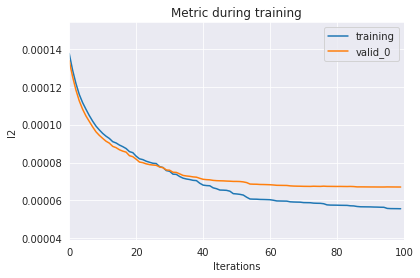

In [173]:
plot_metric(model)

Выведем графики

In [174]:
plot_predictions(X_test, y_test, y_pred_m, stock_code=stock_code)

In [175]:
plot_return_pred(X_test, y_test, y_pred_m, stock_code=stock_code)

In [176]:
plot_pred_price(X_test, y_test, y_pred_m, stock_code=stock_code)

Получим результат

Ранжирование по среднему за все время

In [93]:
submission = X[['Year', 'Month', 'Day', 'SecuritiesCode']]
cols = ['Date', 'SecuritiesCode', 'Target', 'Rank']
submission['Target'] = model.predict(X)
submission['Date'] = pd.to_datetime(submission[['Year', 'Month', 'Day']])
submission.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

In [94]:
df = X.join(y)

In [95]:
max_targets = pd.DataFrame(df.groupby(['SecuritiesCode'])['Target'].max()).reset_index()
max_targets = max_targets.merge(df[['SecuritiesCode', 'Target', 'Date']], on=['SecuritiesCode', 'Target'])

In [178]:
import time
submission = pd.DataFrame(submission.groupby('SecuritiesCode')['Target'].mean().sort_values(ascending=False))
Rank = np.arange(2000)
submission['Rank'] = Rank
submission = submission.merge(max_targets, on='SecuritiesCode')
submission['Date'] = submission['Date'].apply(lambda x: pd.to_datetime(f"{str(x)[:4]}-{str(x)[4:6]}-{str(x)[6:]}"))
submission.drop('Target_y', axis=1, inplace=True)
submission.rename(columns={'Target_x': 'Target'}, inplace=True)
submission = submission[cols]
submission.to_csv(f'submission{int(time.time())}.csv')

In [179]:
submission

,Date,SecuritiesCode,Target,Rank
0,2020-06-16,7095,0.003202,0
1,2020-04-15,4490,0.002870,1
2,2017-09-25,5918,0.002848,2
3,2017-09-25,5805,0.002815,3
4,2020-10-13,4051,0.002800,4
...,...,...,...,...
1995,2020-08-24,4056,-0.002093,1995
1996,2019-06-11,4382,-0.002754,1996
1997,2021-09-09,4058,-0.002934,1997
1998,2019-04-15,6572,-0.003308,1998


Посчитаем коэффициент Шарпа

In [180]:
def ranking_by_date(df, date):
  date_predict = df[df['Date'] == date]
  #date_predict['Target'] = model.predict(date_predict)
  #date_predict = date_predict[date_predict['Date'] == date]
  date_predict = date_predict.sort_values('Target', ascending=False)
  Rank = np.arange(len(date_predict))
  date_predict['Rank'] = Rank
  return date_predict

In [181]:
%%time

df_ = X.copy()
df_['Target'] = model.predict(X)
dates = df_['Date'].unique()

ranked_by_date = ranking_by_date(df_, dates[0])
for date in tqdm(dates[1:]):
    ranked_by_date = pd.concat([ranked_by_date, ranking_by_date(df_, date)])

  0%|          | 0/1158 [00:00<?, ?it/s]

CPU times: user 1min, sys: 5.49 s, total: 1min 6s
Wall time: 59.3 s


In [182]:
def calc_spread_return_sharpe(df, portfolio_size = 250, toprank_weight_ratio = 2) -> float:
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [183]:
calc_spread_return_sharpe(ranked_by_date)

1.0074820872926977

In [ ]:
plot_predictions(X_test, y_test, y_pred_m, stock_code=7095)

In [ ]:
plot_return_pred(X_test, y_test, y_pred_m, stock_code=7095)

In [ ]:
plot_pred_price(X_test, y_test, y_pred_m, stock_code=7095)